<a href="https://colab.research.google.com/github/Laeti-dev/Project4-Credit-Scoring-Model/blob/EDA/ikusawa_laetitia_1_notebook_0824.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on [this kaggle notebook](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook#Read-in-Data)

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Exploration

There are 9 data files and 1 file explaining the variables that we'll load to understand our data.

## Columns description

In [27]:
columns_descrition = pd.read_csv('./data/HomeCredit_columns_description.csv', encoding='latin1', index_col=0)

In [28]:
columns_descrition['Table'].unique()

array(['application_{train|test}.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

In [29]:
application_description = columns_descrition[columns_descrition['Table'] == 'application_{train|test}.csv']

We will work on the application_train file to start with because it contains our target.

## Application

In [30]:
application_train = pd.read_csv('./data/application_train.csv')

In [31]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,...,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,...,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,...,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,...,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,...,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
application_train.shape

(307511, 122)

The training dataset has 307,511 rows where each row is a loan application and 122 columns including our target (TARGET).

In [33]:
appliclation_test = pd.read_csv('./data/application_test.csv')
appliclation_test.shape

(48744, 121)

The testing dataset contains only 48,744 rows.

Lest's explore our train data

# EDA

## Target column distribution

In [34]:
application_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

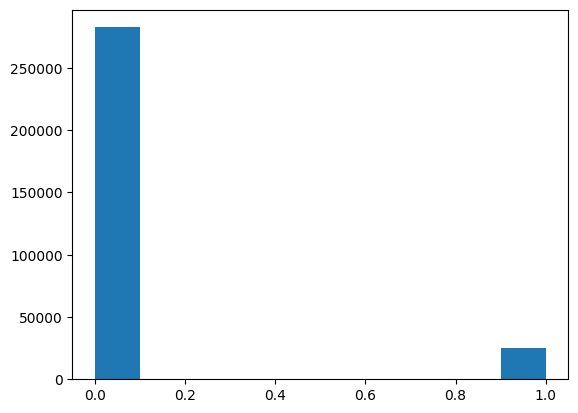

In [35]:
fig, ax = plt.subplots()

ax.hist(application_train['TARGET'])
plt.show()

We observe that this is an imbalanced class. A lot more loans have been reapaid con time than loans that were not repaid.

## Missing values

In [36]:
def missing_values_table(df):
  """
  Takes the dataframe and display missing values count and ratio
  """
  # Total missing values
  mis_val = df.isnull().sum()

  # Ratio of missing values
  mis_val_ratio = 100 * df.isnull().sum() / len(df)

  # Make a table with the results
  mis_val_table = pd.concat([mis_val, mis_val_ratio], axis=1)

  # Rename the columns
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'})

  # Sort the table by ratio of missing descending
  mis_val_table_ren_columns = mis_val_table_ren_columns[
      mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)

  # Print some summary information
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
      "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")

  # Return the dataframe with missing information
  return mis_val_table_ren_columns

In [37]:
missing_values = missing_values_table(application_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


## Columns type

In [38]:
# Number of each type of column
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

## Categorical variables

In [13]:
# Number of unique classes in each object column
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [39]:
categorical_vars = application_train.select_dtypes(include='object').columns.tolist()
print(categorical_vars)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


Get details on the variables

In [43]:
# Set the option to display full length of a column
pd.set_option('display.max_colwidth', None)
application_description[application_description['Row'].isin(categorical_vars)][["Row", "Description", "Special"]]

,Row,Description,Special
5,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,CODE_GENDER,Gender of the client,NaN
7,FLAG_OWN_CAR,Flag if the client owns a car,NaN
8,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
14,NAME_TYPE_SUITE,Who was accompanying client when he was applying for the loan,NaN
15,NAME_INCOME_TYPE,"Clients income type (businessman, working, maternity leave, )",NaN
16,NAME_EDUCATION_TYPE,Level of highest education the client achieved,NaN
17,NAME_FAMILY_STATUS,Family status of the client,NaN
18,NAME_HOUSING_TYPE,"What is the housing situation of the client (renting, living with parents, ...)",NaN
31,OCCUPATION_TYPE,What kind of occupation does the client have,NaN


Except for ORGANIZATIO_TYPE then OCCUPATION_TYPE, categorical variables have a small amount of unique values.

### Encoding

For categorical variables with 2 classes => Label Encoding
For more than 2 classes => One Hot Encoding

In [14]:
from sklearn.preprocessing import LabelEncoder

In [44]:
# Create the label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in application_train:
    if application_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(application_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(application_train[col])
            # Transform both training and testing data
            application_train[col] = le.transform(application_train[col])
            appliclation_test[col] = le.transform(appliclation_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [45]:
# one-hot encoding of categorical variables
application_train = pd.get_dummies(application_train)
appliclation_test = pd.get_dummies(appliclation_test)

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', appliclation_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


It appears that application_test has variables with fewer categories. We need to align application_train and application_test by their columns (axis=1).

In [46]:
# The target is in the training data but not in the testing data, so we need to keep the target on the side
train_labels = application_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
application_train, appliclation_test = application_train.align(appliclation_test, join = 'inner', axis = 1)

# Add the target back in
application_train['TARGET'] = train_labels

print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', appliclation_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


Training and testing datasets have now the same features that is a prerequisit for ML model.